In [ ]:
# Imports
library(Seurat)
library(dplyr)
library(celldex)
library(ggplot2)
library(SingleR)
library(scater)
library(SingleCellExperiment)
library(SeuratDisk)
library(gridExtra)
library(zellkonverter)
library(clustree)

Warning message:
"package 'dplyr' was built under R version 4.4.2"



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.4.2"

Attaching package: 'matrixStats'


The following object is masked from 'package:dplyr':

    count



Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMad

In [ ]:
# Set wd
setwd("../R Objects/Raw Seurat R Objects")
Dib <- readRDS("Dib_raw.rds")

# Dib RDS object was converted to v3 instead of v5
Dib <- UpdateSeuratObject(Dib)

# Export R object for all mice integration
dib[["Species"]] <- "Human"

[1] "all_mice_macrophages_annotated.rds"         
 [2] "all_mice_myeloid_data.rds"                  
 [3] "Bashore_raw.rds"                            
 [4] "Cochaine_raw.rds"                           
 [5] "Cochaine_raw_modified_orig.rds"             
 [6] "Dib_and_Horstmann_macrophages_annotated.rds"
 [7] "Dib_macrophages_annotated.rds"              
 [8] "Dib_raw.rds"                                
 [9] "Fernandez_raw.rds"                          
[10] "Horstmann_macrophages_annotated.rds"        
[11] "Horstmann_raw.rds"                          
[12] "Menno_raw.rds"                              
[13] "Vafadarnejad_raw.rds"                       
[14] "Vafadarnejad_raw_modified_orig.rds"         
[15] "Winkels_raw.rds"                            
[16] "Winkels_raw_modified_orig.rds"

[1] "c:/Users/phili/Desktop/BMW Jaar 3/Afstudeerscriptie/project_scriptie/Data/R Objects/Raw Seurat R Objects"

ERROR: Error in h5checktypeOrOpenLoc(file, readonly = TRUE, fapl = NULL, native = native): Error in h5checktypeOrOpenLoc(). Cannot open file. File 'c:\Users\phili\Desktop\BMW Jaar 3\Afstudeerscriptie\project_scriptie\Data\R Objects\Raw Seurat R Objects\GSE210152_raw.h5ad' does not exist.


In [3]:
ncol(Dib)

[1] 34456

In [72]:
# Split by patient
splitted_dib <- SplitObject(Dib, split.by = "patient")

# Assign patient objects 
splitted_dib$P1$orig.ident <- "P1"
splitted_dib$P2$orig.ident <- "P2"
splitted_dib$P3$orig.ident <- "P3"
splitted_dib$P5$orig.ident <- "P5"
splitted_dib$P6$orig.ident <- "P6"
splitted_dib$P7$orig.ident <- "P7"

# Merge the Seurat objects
samples <- merge(splitted_dib$P1, y=list(splitted_dib$P2, splitted_dib$P3, splitted_dib$P5, splitted_dib$P6, splitted_dib$P7))

In [73]:
# Preprocessing function which performs a basic workflow for scRNA seq analysis
pre_process <- function(data, nFeatures_RNA = 200, nCounts_RNA = 3, percents.mt = 5, pattern = "MT", resolutions = seq(0.5, 1.5, by = 0.1), k.weights = 100) {
    # Split
    data[["RNA"]] <- split(data[["RNA"]], f = data$orig.ident)

    # Get percentage mt                      
    data[["percent.mt"]] <- PercentageFeatureSet(data, pattern = sprintf("^%s-", pattern))

    # Subsets
    data <- subset(x = data, subset = nFeature_RNA >= nFeatures_RNA & nCount_RNA >= nCounts_RNA & percent.mt <= percents.mt)

    # Normalization
    data <- NormalizeData(data, normalization.method = "LogNormalize", scale.factor = 10000)
    
    # Find Variable features
    data <- FindVariableFeatures(data, selection.method = "vst", nfeatures = 2000)
    
    # Scale Data
    data <- ScaleData(data, vars.to.regress = c("percent.mt", "nFeature_RNA"))
    
    # Run PCA
    data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)

    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.05))

    # Run UMAP
    data <- RunUMAP(data, reduction = "pca", dims = 1:significant_pcs, verbose=FALSE)

    # Integrate # Replaced CCA by Harmony
    data <- IntegrateLayers(object = data, method = CCAIntegration, orig.reduction = "pca", new.reduction = "integrated.cca", k.weight = k.weights)

    data[["RNA"]] <- JoinLayers(data[["RNA"]])

    # Post integration processing
    data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)

    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.05))

    # Clustering
    data <- FindNeighbors(data, reduction = "integrated.cca", dims = 1:significant_pcs)
    data <- FindClusters(data, resolution = resolutions)
    data <- RunUMAP(data, dims = 1:significant_pcs, reduction = "integrated.cca", verbose=FALSE)

    return(data)
}

data <- pre_process(samples, pattern= "MT", percents.mt = 10)

Warning message:
"Input is a v3 assay and `split()` only works for v5 assays; converting
• to a v5 assay"
Warning message:
"Assay RNA changing from Assay to Assay5"
Normalizing layer: counts.P1

Normalizing layer: counts.P2

Normalizing layer: counts.P3

Normalizing layer: counts.P5

Normalizing layer: counts.P6

Normalizing layer: counts.P7

Finding variable features for layer counts.P1

Finding variable features for layer counts.P2

Finding variable features for layer counts.P3

Finding variable features for layer counts.P5

Finding variable features for layer counts.P6

Finding variable features for layer counts.P7

Regressing out percent.mt, nFeature_RNA

Centering and scaling data matrix

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9678 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7011 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7447 anc

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29521
Number of edges: 1167151

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9103
Number of communities: 16
Elapsed time: 7 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29521
Number of edges: 1167151

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9017
Number of communities: 18
Elapsed time: 7 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29521
Number of edges: 1167151

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8936
Number of communities: 19
Elapsed time: 7 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29521
Number of edges: 1167151

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8854
Number of communities: 20
Elapsed time: 8 seconds
Modulari

0    1    2    3    4    5    6    7    8   9    10  11  12 
Adipocytes           0    0    0    0    3    0    0    0   0    0   0   0   0
B-cells              0    8    0    0    0    0    0    0   0    0   0   0 699
CD4+ T-cells       859 1596    0  431    0    2    0    0 667    0 217   0   3
CD8+ T-cells      3662 1707    2 2330   19   89 1194 1568 498   10 698   6  34
DC                   0    1    0    1    2    1    0    0   0    0   0  71   0
Endothelial cells    0    1    0    0    1    0    0    0   0    0   0   0   0
Erythrocytes         0    0    0    0    0    0    0    0   0    0   0   0   0
Fibroblasts          0    0    0    0    2    0    0    0   0    0   0   0   0
HSC                  1    4    0    3    0   14    0    0   0    0   2   2   4
Macrophages          4   10  143    1 2031    0    0    0   1    0   0  19   0
Monocytes           19   32 2869   25  630    7    4    3  11    0   3 912   8
Myocytes             0    0    0    0    1    0    0    0   0    0   0   0   0
Neutrophils          0    0   22    0    0    0    0    0   0    0   0   0   0
NK cells            80  159    0  140   12 2097  767  128   3 1067 107   1   4
                  13  14  15  16  17 
Adipocytes          0   0   0   0   0
B-cells             0 200 307   0   0
CD4+ T-cells       46   1   1   0   0
CD8+ T-cells      250   8  26   1   1
DC                  0   0   0   0  16
Endothelial cells   0   0   0   0   0
Erythrocytes        0   0   0   3   0
Fibroblasts         0   0   0   0   0
HSC                 8  58   0 196   3
Macrophages        40   0   1   2   3
Monocytes          32 208  17  43 114
Myocytes            0   0   0   0   0
Neutrophils         0   0   0   0   0
NK cells          179   2   4   4   0

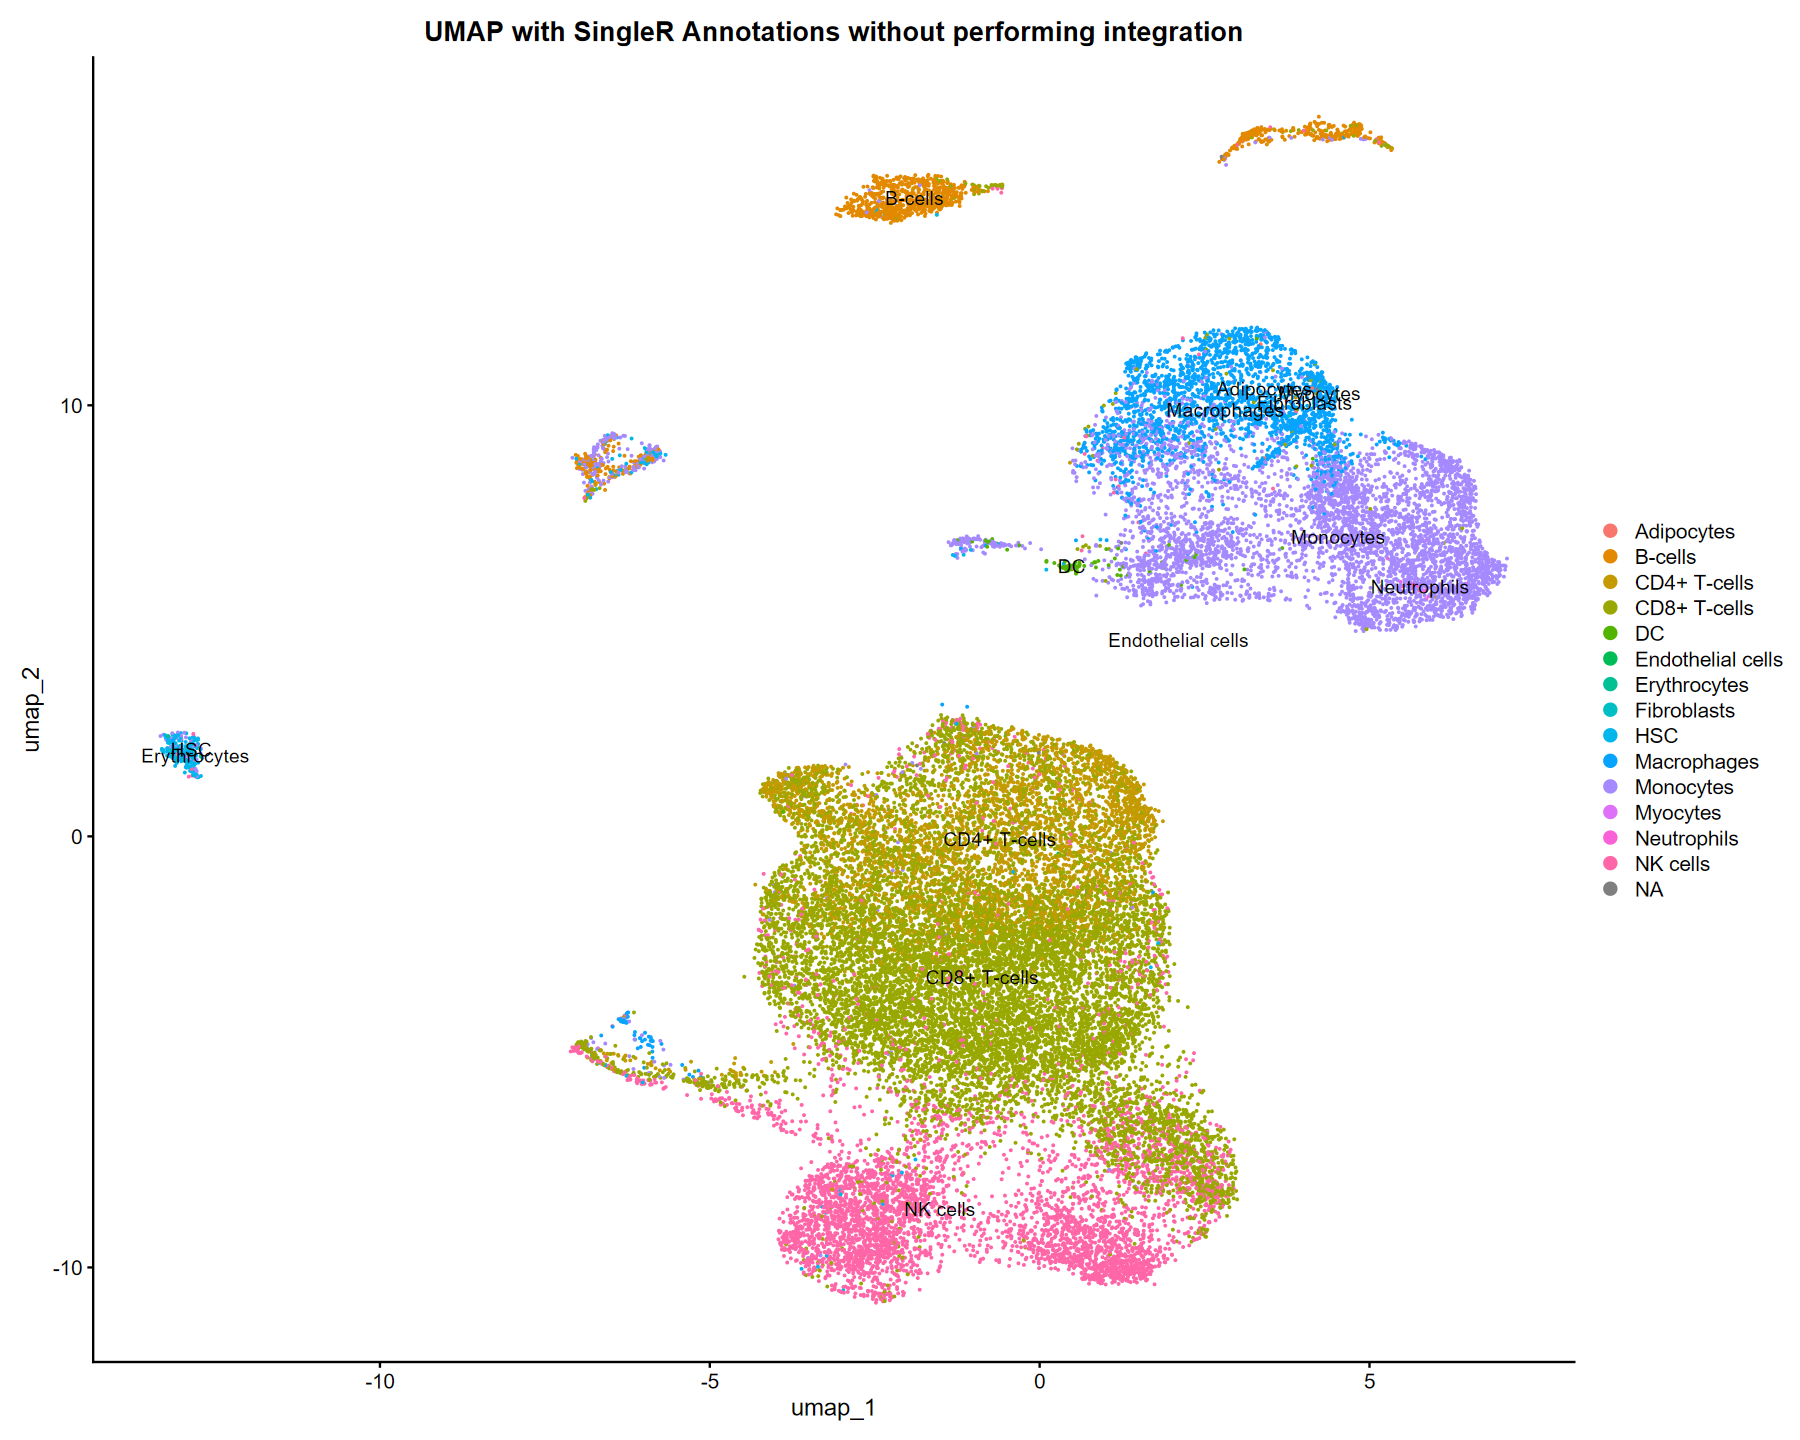

In [75]:
# Annotation code block

# Get reference atlas
data[["RNA"]] <- JoinLayers(data[["RNA"]])
hpca.se <- celldex::BlueprintEncodeData()
data.sce <- as.SingleCellExperiment(data)

# Predict
pred.hpca <- SingleR(test = data.sce, ref = hpca.se, assay.type.test=1,
    labels = hpca.se$label.main)

# View annotations
cluster_table <- cbind(table(pred.hpca$pruned.labels, data.sce$seurat_clusters))
cluster_table

# Add SingleR predicted labels to Seurat metadata
data$SingleR_Labels <- pred.hpca$pruned.labels

# UMAP plot with SingleR labels
DimPlot(data, reduction = "umap", group.by = "SingleR_Labels", label = TRUE) + 
    ggtitle("UMAP with SingleR Annotations without performing integration")

In [76]:
saveRDS(data, file = "dib_integrated.rds")

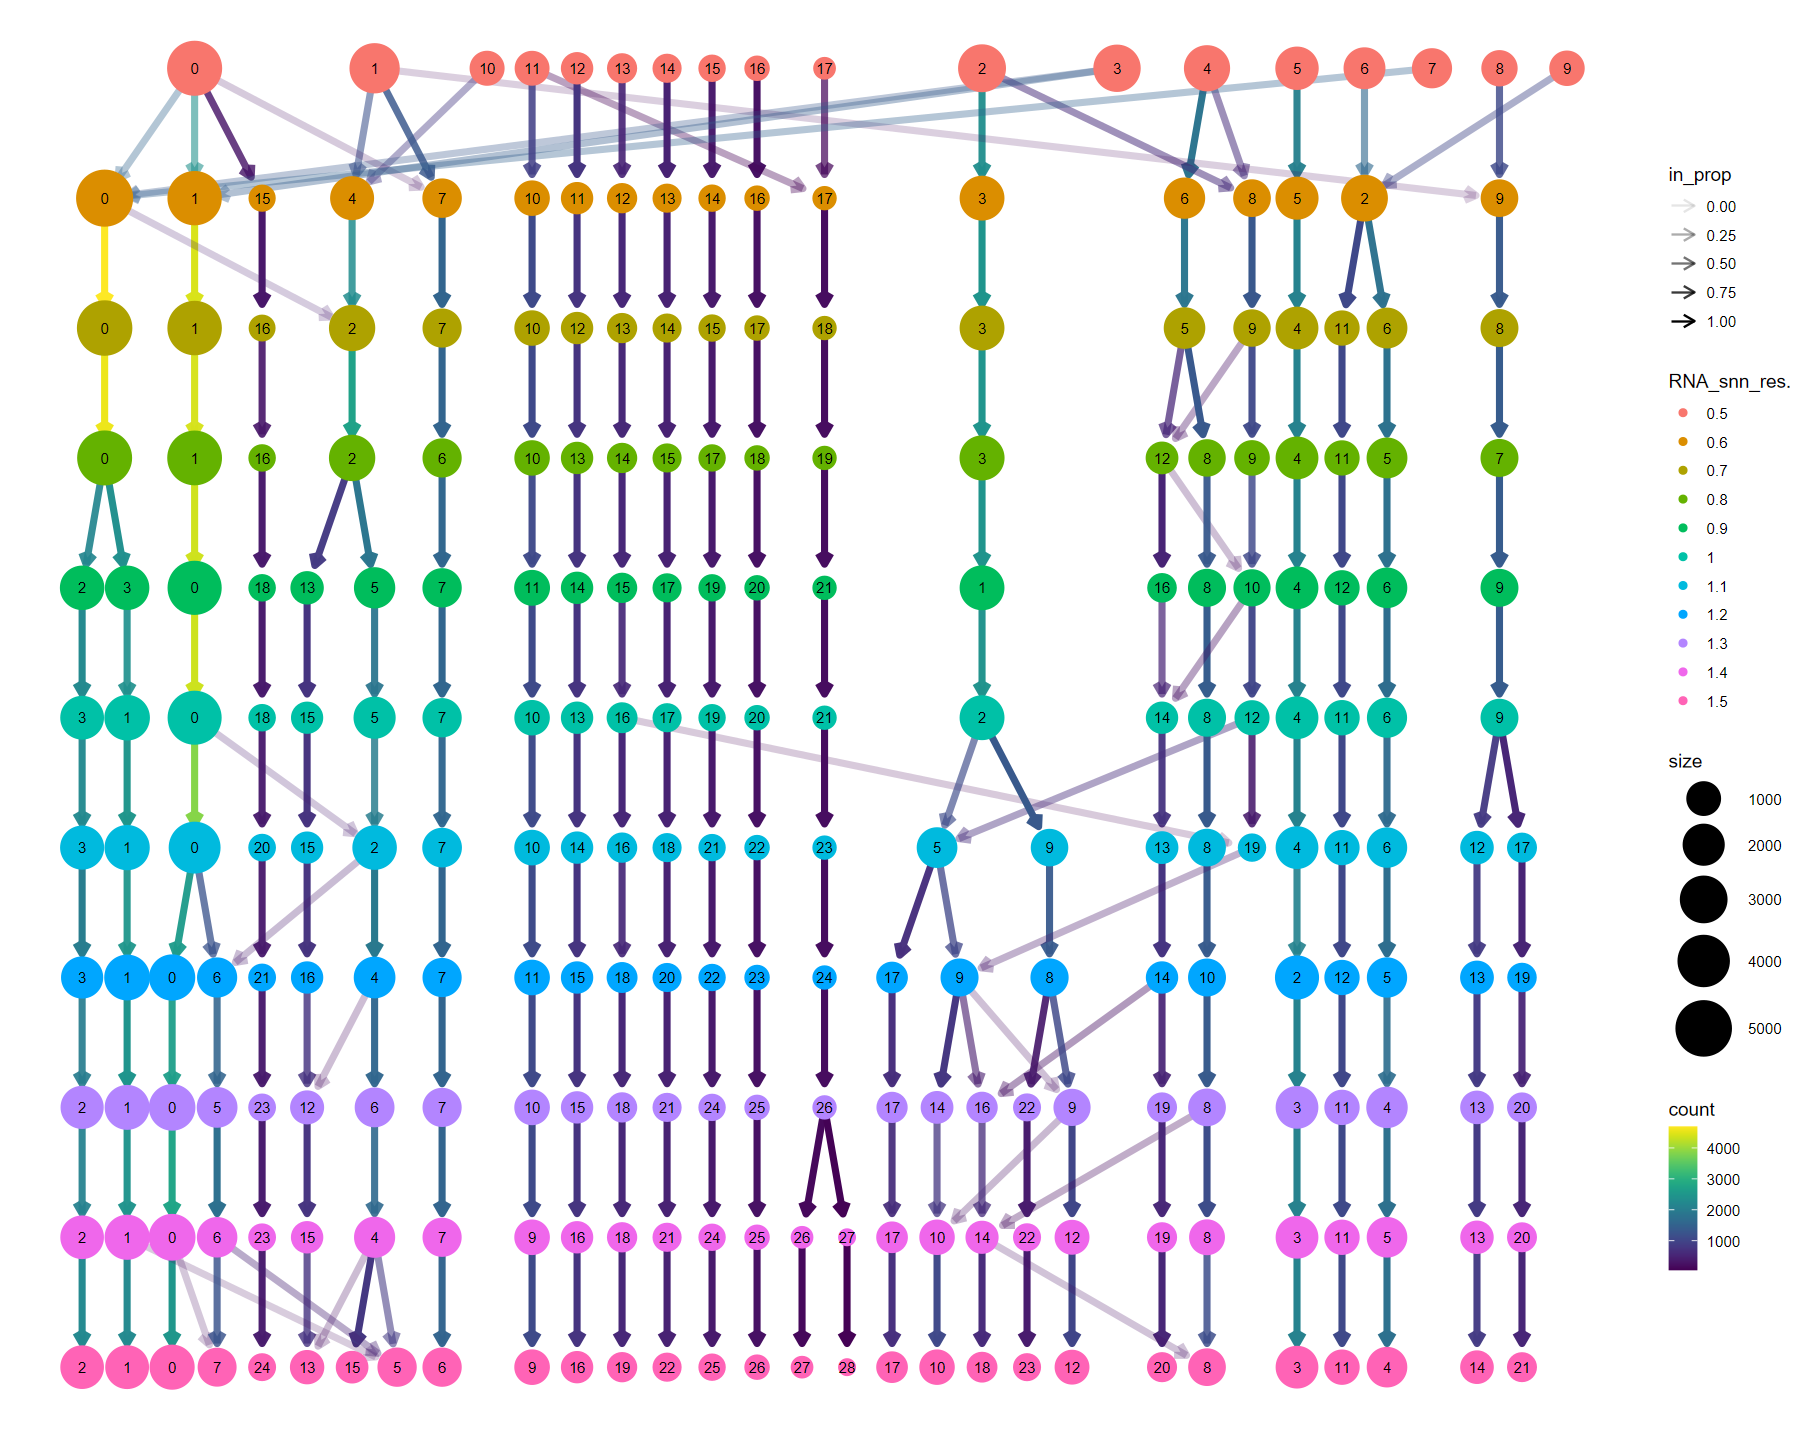

In [77]:
# This cell is meant to analyze the different resolutions and see which one is the best
clustree(data, prefix= "RNA_snn_res.", layout = "sugiyama")

In [78]:
# Assign the slot "Seurat Cluster" to the desired resolution
data$seurat_clusters <- data$`RNA_snn_res.0.5`

0    1    2    3    4    5    6    7    8   9    10  11  12 
Adipocytes           0    0    0    0    3    0    0    0   0    0   0   0   0
B-cells              0    8    0    0    0    0    0    0   0    0   0   0 699
CD4+ T-cells       859 1596    0  431    0    2    0    0 667    0 217   0   3
CD8+ T-cells      3662 1707    2 2330   19   89 1194 1568 498   10 698   6  34
DC                   0    1    0    1    2    1    0    0   0    0   0  71   0
Endothelial cells    0    1    0    0    1    0    0    0   0    0   0   0   0
Erythrocytes         0    0    0    0    0    0    0    0   0    0   0   0   0
Fibroblasts          0    0    0    0    2    0    0    0   0    0   0   0   0
HSC                  1    4    0    3    0   14    0    0   0    0   2   2   4
Macrophages          4   10  143    1 2031    0    0    0   1    0   0  19   0
Monocytes           19   32 2869   25  630    7    4    3  11    0   3 912   8
Myocytes             0    0    0    0    1    0    0    0   0    0   0   0   0
Neutrophils          0    0   22    0    0    0    0    0   0    0   0   0   0
NK cells            80  159    0  140   12 2097  767  128   3 1067 107   1   4
                  13  14  15  16  17 
Adipocytes          0   0   0   0   0
B-cells             0 200 307   0   0
CD4+ T-cells       46   1   1   0   0
CD8+ T-cells      250   8  26   1   1
DC                  0   0   0   0  16
Endothelial cells   0   0   0   0   0
Erythrocytes        0   0   0   3   0
Fibroblasts         0   0   0   0   0
HSC                 8  58   0 196   3
Macrophages        40   0   1   2   3
Monocytes          32 208  17  43 114
Myocytes            0   0   0   0   0
Neutrophils         0   0   0   0   0
NK cells          179   2   4   4   0

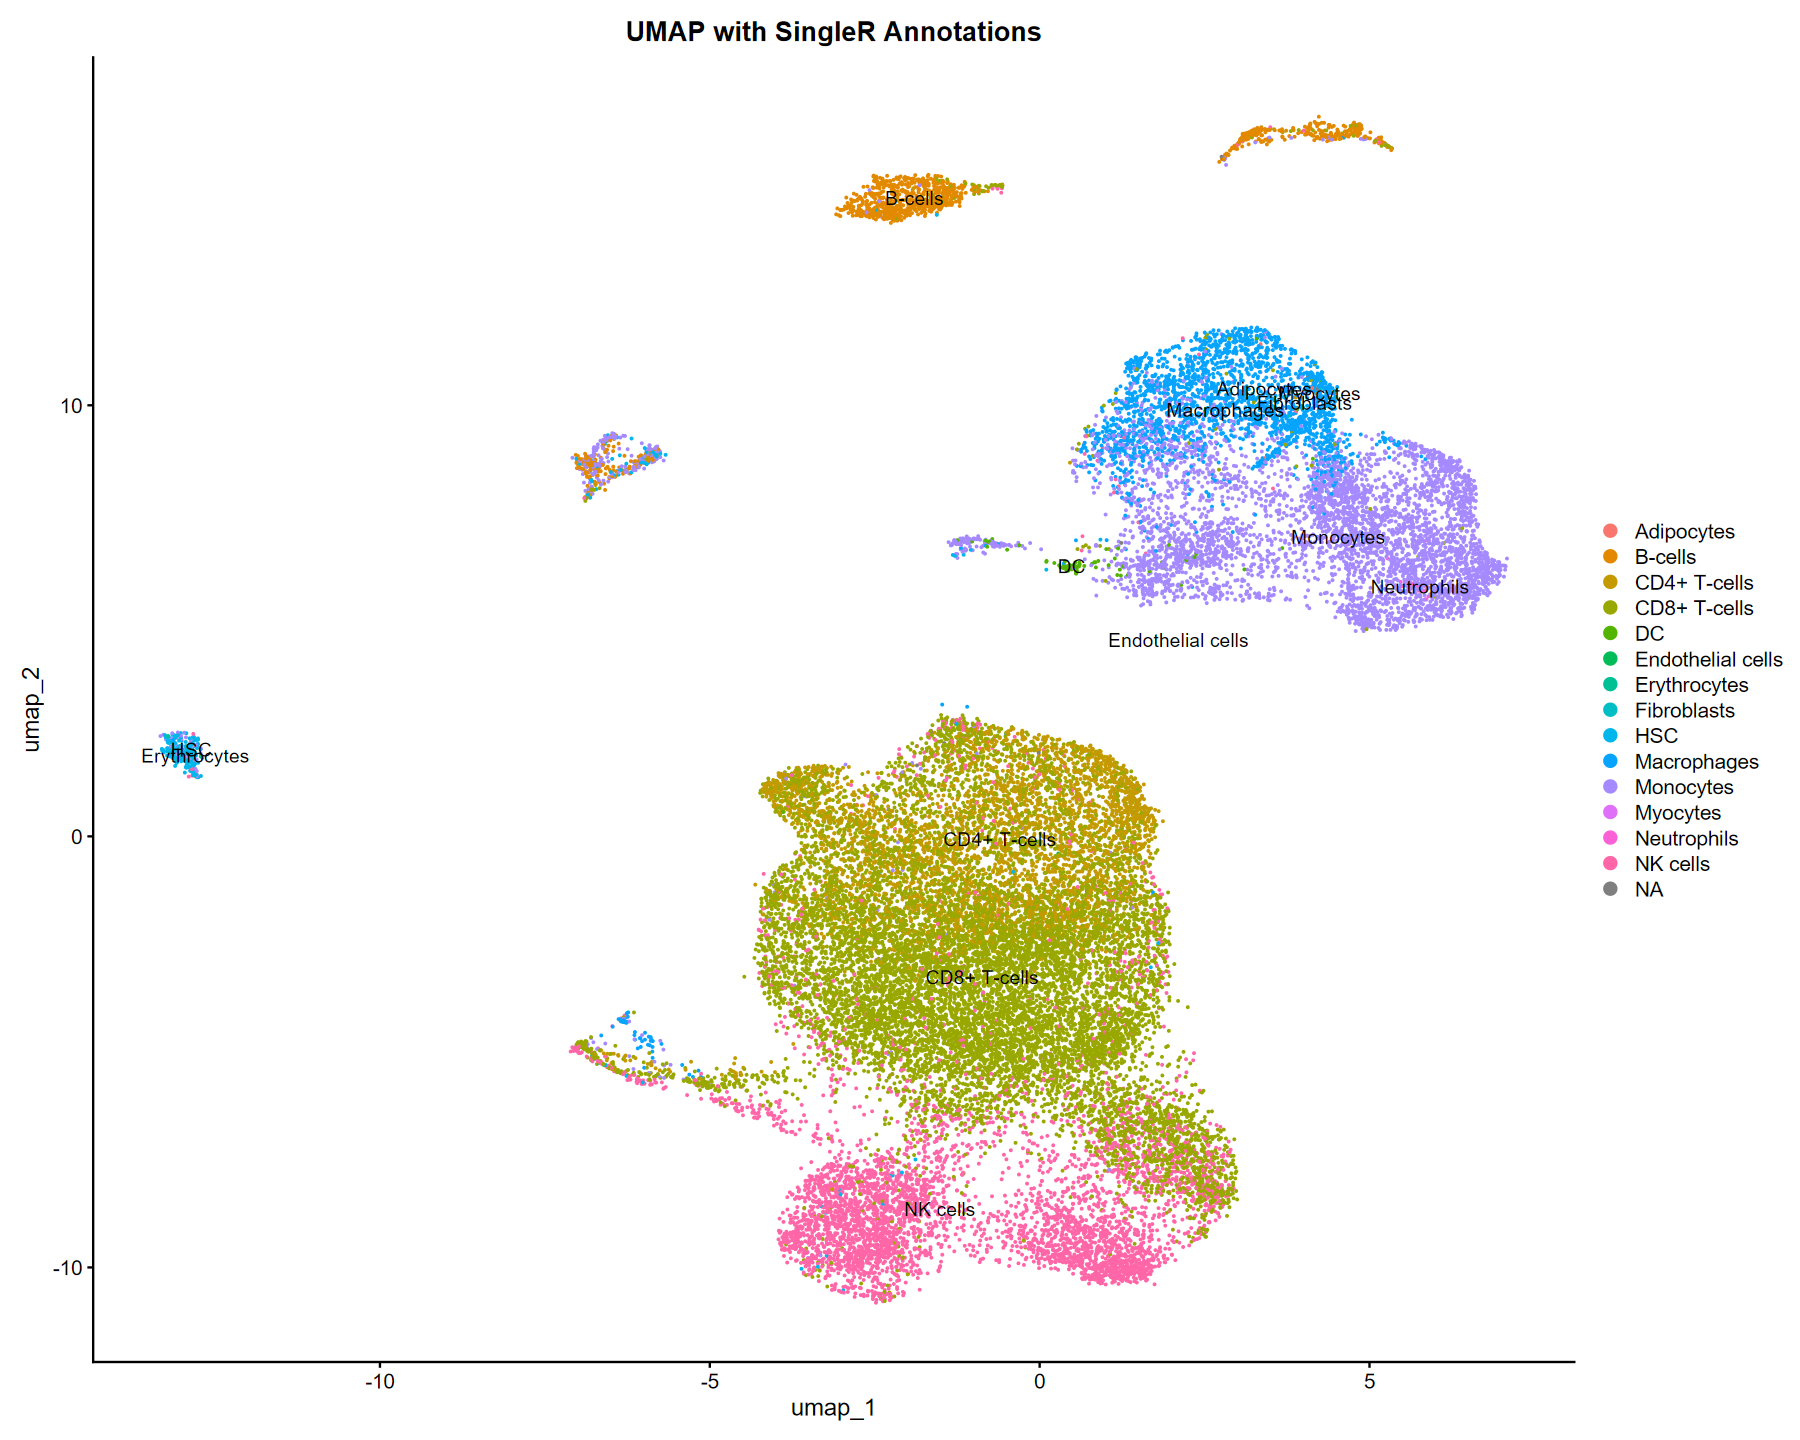

In [79]:
# Annotation code block

# Get reference atlas
hpca.se <- celldex::BlueprintEncodeData()
data.sce <- as.SingleCellExperiment(data)

# Predict
pred.hpca <- SingleR(test = data.sce, ref = hpca.se, assay.type.test=1,
    labels = hpca.se$label.main)

# View annotations
cluster_table <- cbind(table(pred.hpca$pruned.labels, data.sce$seurat_clusters))
cluster_table

# Add SingleR predicted labels to Seurat metadata
data$SingleR_Labels <- pred.hpca$pruned.labels

# UMAP plot with SingleR labels
DimPlot(data, reduction = "umap", group.by = "SingleR_Labels", label = TRUE) + 
    ggtitle("UMAP with SingleR Annotations")

In [1]:
# Function to get the a specific cell type
get_macrophages <- function(data, table, cell_type = "Macrophages") {

    # Find clusters where atleast > 15% is classified as macrophages
    clusters <- which(t(cluster_table[cell_type, ] / colSums(cluster_table) * 100) > 5) - 1
    
    # Get subsets by first filtering on macrophage dominant clusters
    data <- subset(data, subset = seurat_clusters %in% clusters)

    # And then only select the macrophages
    data <- subset(data, subset = SingleR_Labels == cell_type)

    return(data)
}

macrophages <- get_macrophages(data, cluster_table, cell_type = "Macrophages")

ERROR: Error in get_macrophages(data, cluster_table, cell_type = "Macrophages"): object 'cluster_table' not found


In [82]:
macrophages@assays$RNA

Assay (v5) data with 36601 features for 1999 cells
Top 10 variable features:
 PTGDS, SPP1, TPSB2, TPSAB1, CCL2, APOC1, IGKC, FABP5, S100A8, JCHAIN 
Layers:
 data, counts, scale.data 

In [83]:
# To reintegrate, there needs to be a new Seurat Object created
macrophage_data <- CreateSeuratObject(
    counts = macrophages@assays$RNA$counts,
    meta.data = macrophages@meta.data)

In [84]:
# Reprocess the subset
macrophage_data <- pre_process(macrophage_data, resolutions = seq(0.1, 1, by=0.1))#, k.weights = 58)

Normalizing layer: counts.P1

Normalizing layer: counts.P2

Normalizing layer: counts.P3

Normalizing layer: counts.P5

Normalizing layer: counts.P6

Normalizing layer: counts.P7

Finding variable features for layer counts.P1

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -2.0255"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.49827"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  2.0705e-14"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 0.090619"
Finding variable features for layer counts.P2

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -2.0334"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametri

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1344
Number of edges: 56176

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9095
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1344
Number of edges: 56176

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8516
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1344
Number of edges: 56176

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8118
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1344
Number of edges: 56176

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7767
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer ver

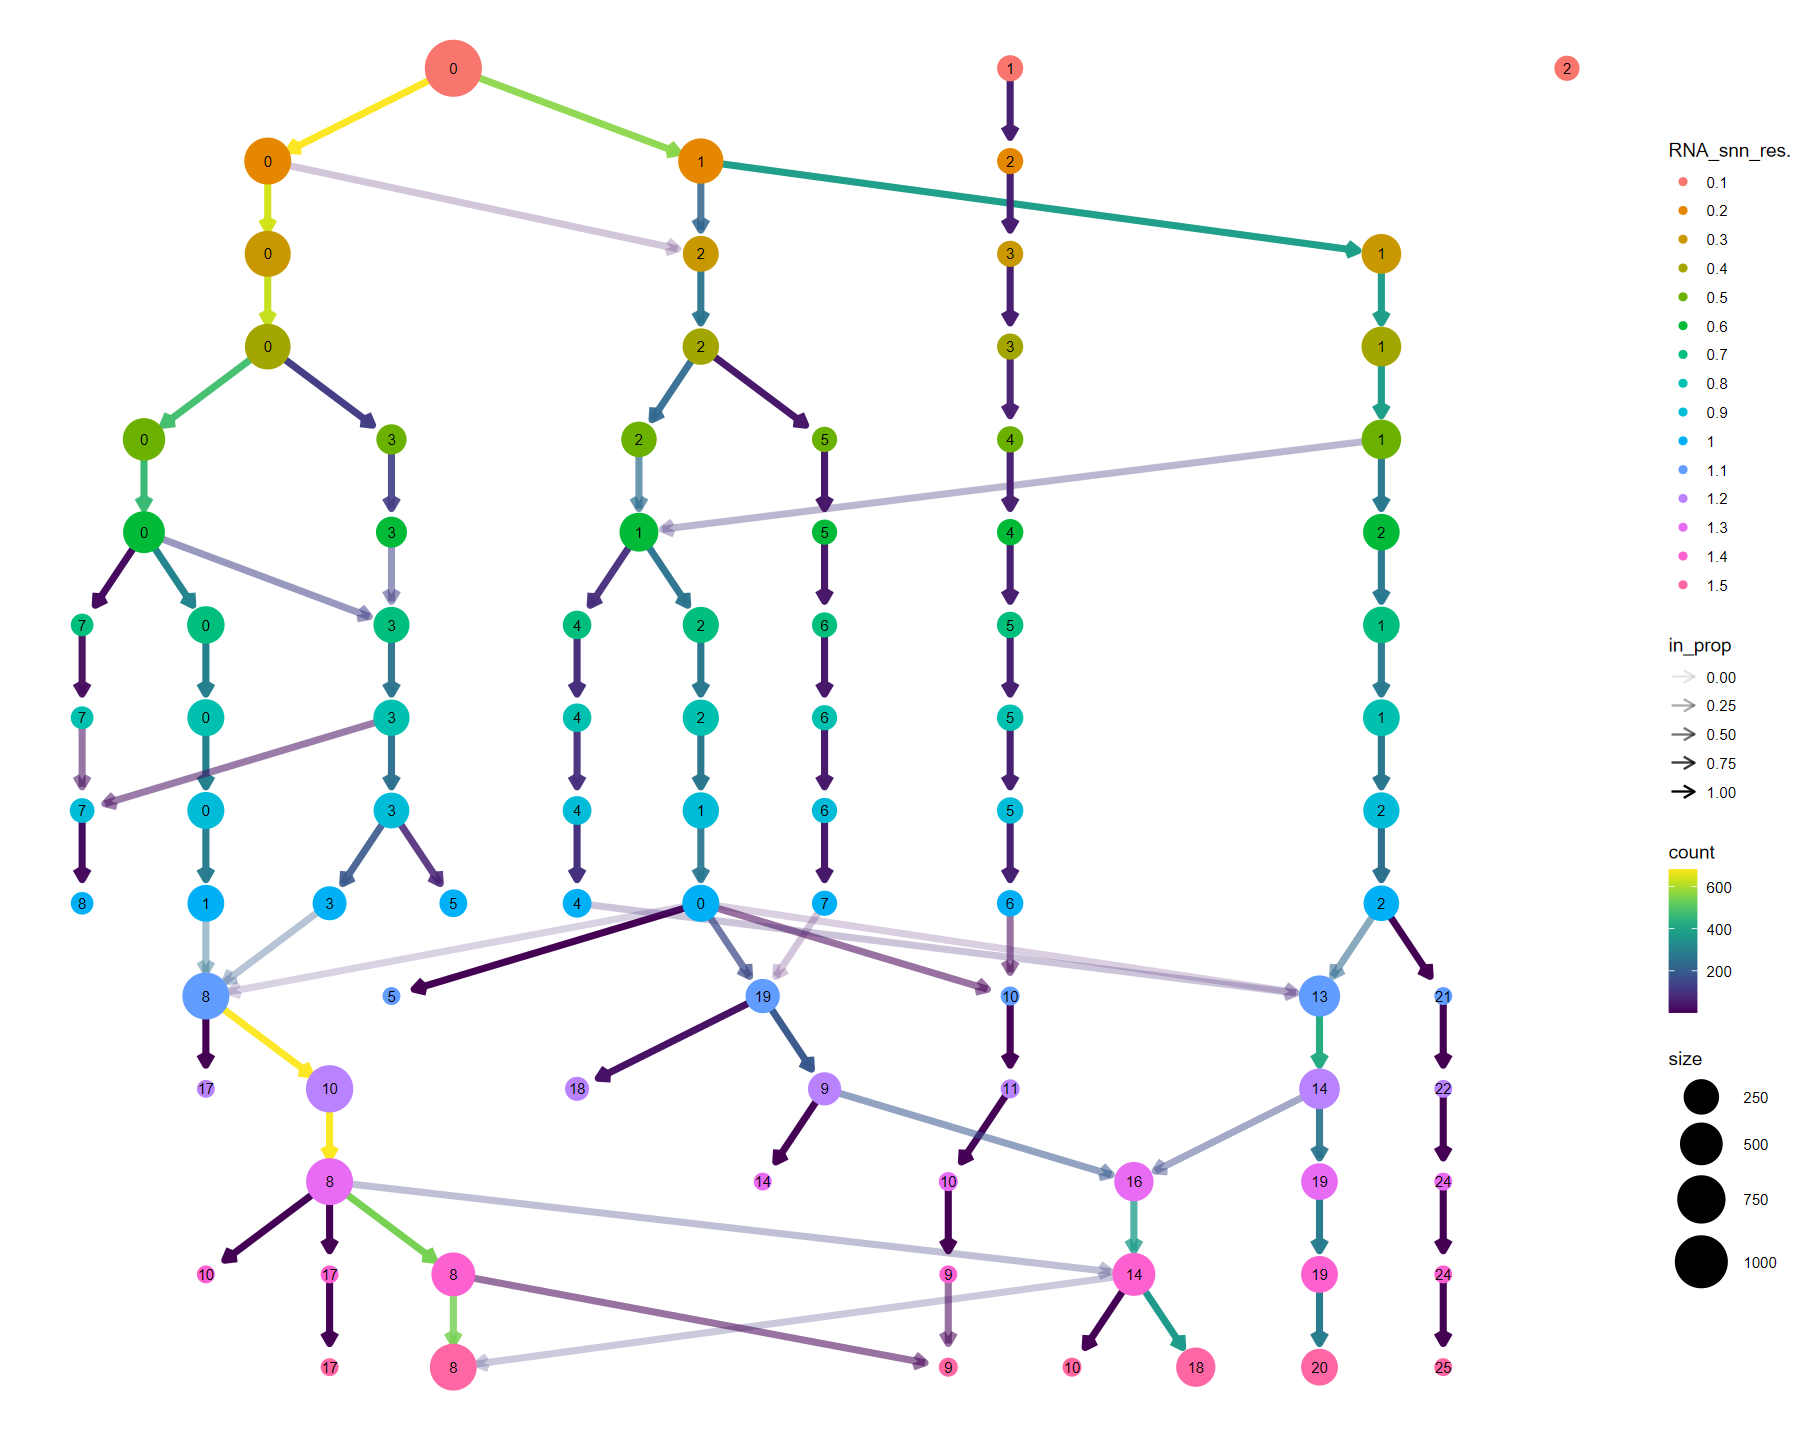

In [85]:
# View the clustree again for the best resolution
clustree(macrophage_data, prefix= "RNA_snn_res.", layout = "sugiyama")

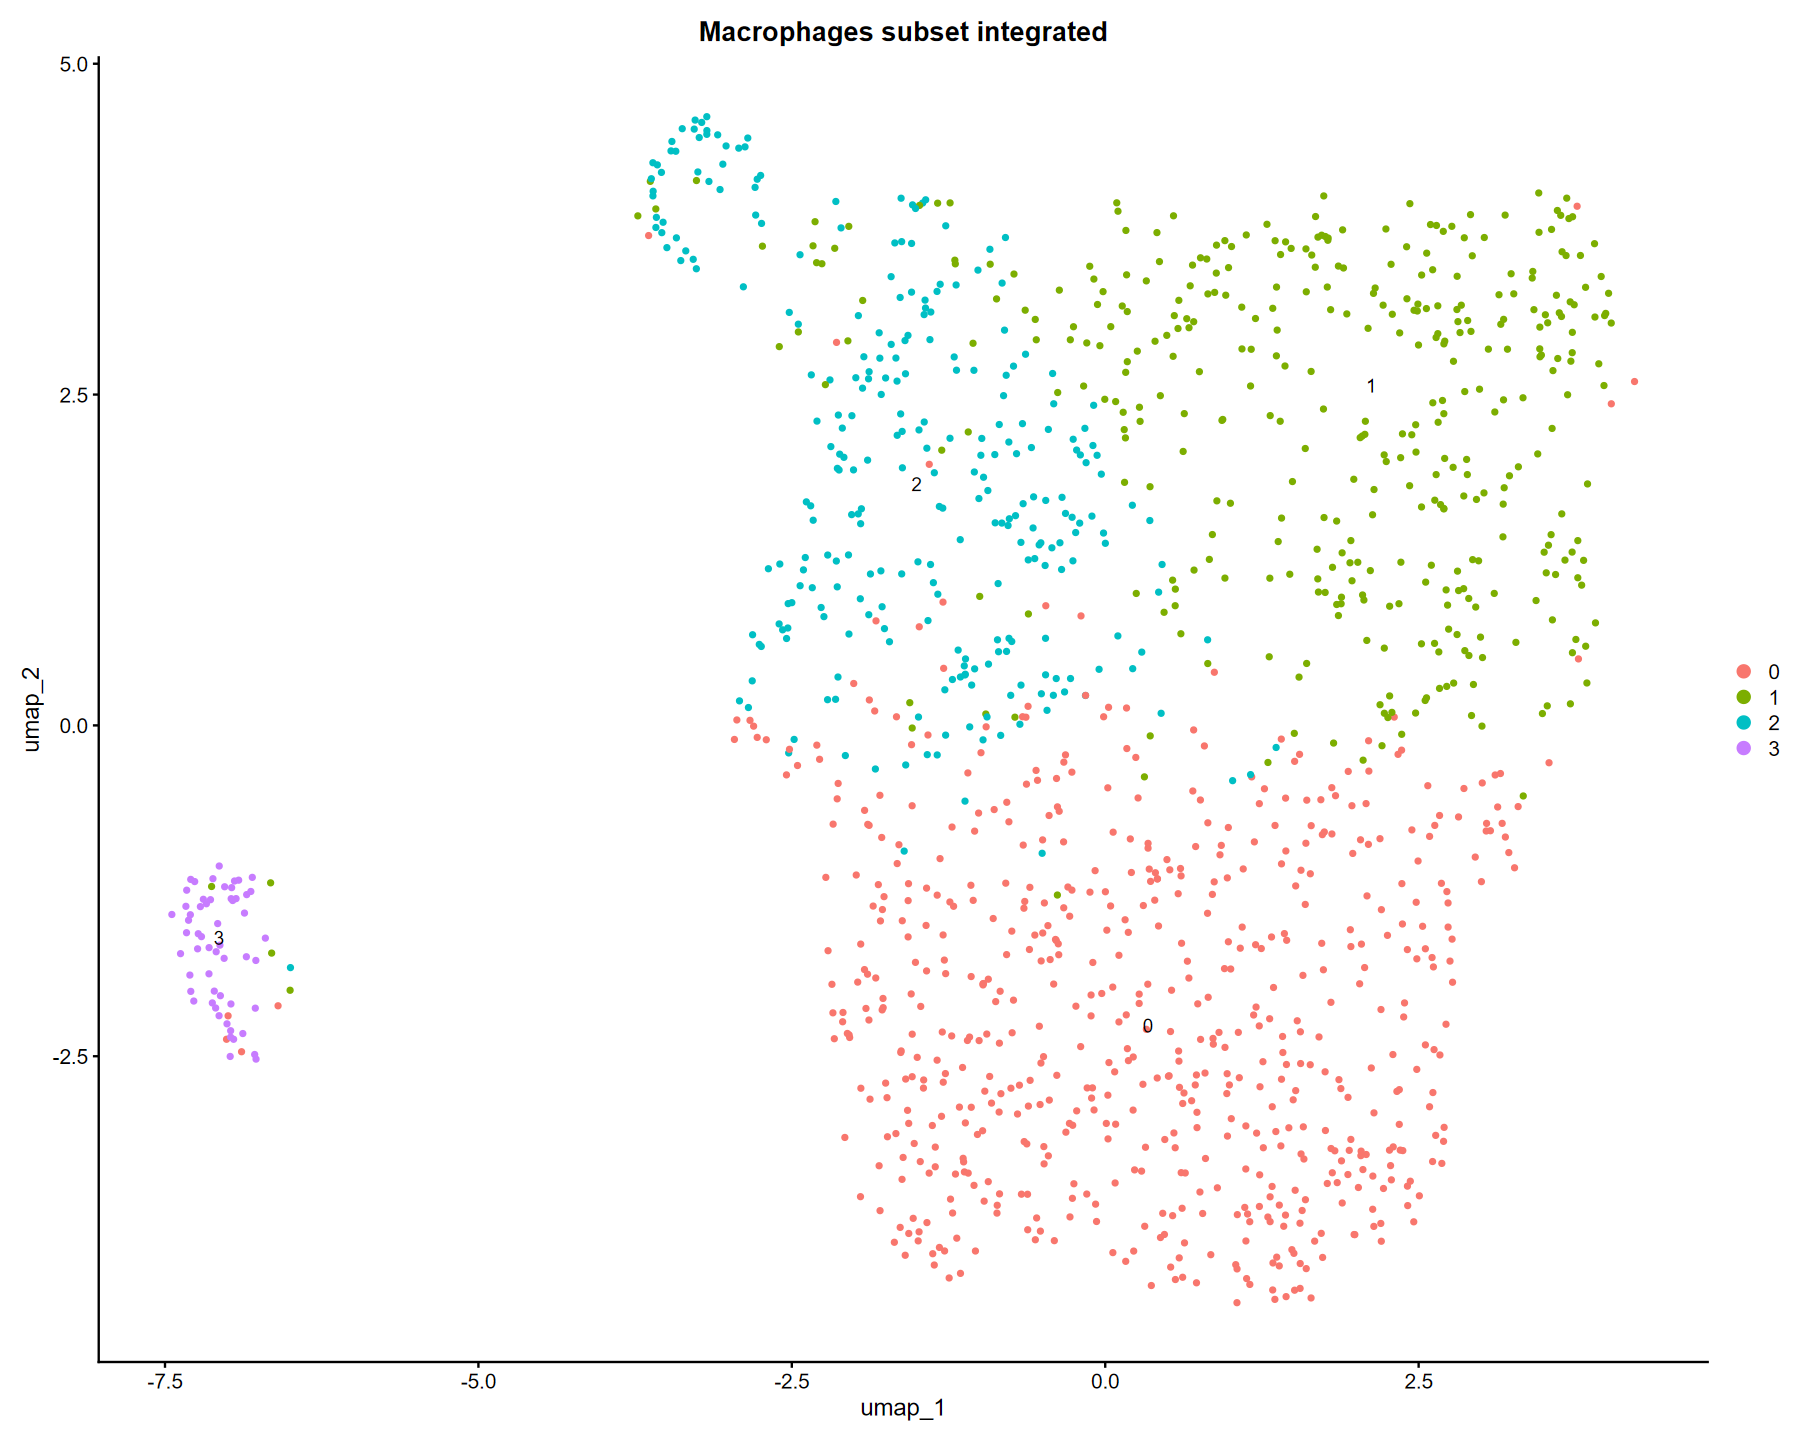

In [86]:
# Assign the slot "Seurat Cluster" to the desired resolution
macrophage_data$seurat_clusters <- macrophage_data$`RNA_snn_res.0.4`
Idents(macrophage_data) <- "seurat_clusters"

# Plot
DimPlot(macrophage_data, reduction = "umap", group.by = "RNA_snn_res.0.4", label = TRUE) + 
    ggtitle("Macrophages subset integrated")

In [87]:
# Some marker genes according to Winther & Willemsen
features_inflammatory <- c("S100A8", "S100A9", "IL1B", "CASP1", "CASP4", "NLRP3", "TNF", "EGR1", "ZPF36", "IER3", "CEPBP", "CXCL2", "CCL2-5")
features_resident <- c("LYVE1", "CX3CR1", "FOLR2", "C1QA", "C1QB", "C1QC", "CD74", "HLA-DRA", "HLA-DRB1", "PF4", "SEPP1", "VSIG4", "F13A1")
features_trem2 <- c("TREM2", "TREM1", "CD9", "FABP5", "APOE", "APOC1", "SPP1", "LGALS3", "CTSB")
features_trem1 <- c("TREM1", "TNF", "CEBPB", "Il1B", "CCL2", "CCL17", "CCL20", "CXCL1", "CXCL2", "CXCL3", "CXCL8" )
features_ifnic <- c("ISG15", "IRF7", "IFIT3", "IFIT1")
features_proliferating <- c("STMN1", "TOP2A", "MKI67", "TUBA1B", "TUBB5")
features_monocytes <- c("CD14", "CD16", "HLA-DR", "CCR2", "CX3CR1", "CD11b", "CD64", "LYZ")



# Add a module score to the Seurat object
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_inflammatory), name = "FeatureGeneScore_inflammatory")
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_resident), name = "FeatureGeneScore_resident_like")
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_trem2), name = "FeatureGeneScore_trem2")

# Vln plots
inflammatory_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_inflammatory1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for inflammatory macrophage markers")
residents_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_resident_like1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for resident-like macrophage markers")
trem2_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_trem21", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for trem2 foamy macrophage markers")

# Visualizing DotPlots to view marker genes
inflammatory_dot <- DotPlot(macrophage_data, features = features_inflammatory) + 
  ggtitle("Inflammatory Macrophages") + RotatedAxis()

resident_dot <- DotPlot(macrophage_data, features = features_resident) + 
  ggtitle("Resident-Like Macrophages")

TREM2_dot <- DotPlot(macrophage_data, features = features_trem2) + 
  ggtitle("TREM2 'Foamy' Macrophages")

IFNIC_dot <- DotPlot(macrophage_data, features = features_ifnic) + 
  ggtitle("IFNIC Macrophages")

proliferating_dot <- DotPlot(macrophage_data, features = features_proliferating) + 
  ggtitle("Proliferating Macrophages")


Warning message:
"The following features are not present in the object: ZPF36, CEPBP, CCL2-5, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: SEPP1, not searching for symbol synonyms"
Warning message:
"The following requested variables were not found: ZPF36, CEPBP, CCL2-5"
Warning message:
"Scaling data with a low number of groups may produce misleading results"
Warning message:
"The following requested variables were not found: SEPP1"
Warning message:
"Scaling data with a low number of groups may produce misleading results"
Warning message:
"Scaling data with a low number of groups may produce misleading results"
Warning message:
"Scaling data with a low number of groups may produce misleading results"
Warning message:
"The following requested variables were not found: TUBB5"
Warning message:
"Scaling data with a low number of groups may produce misleading results"


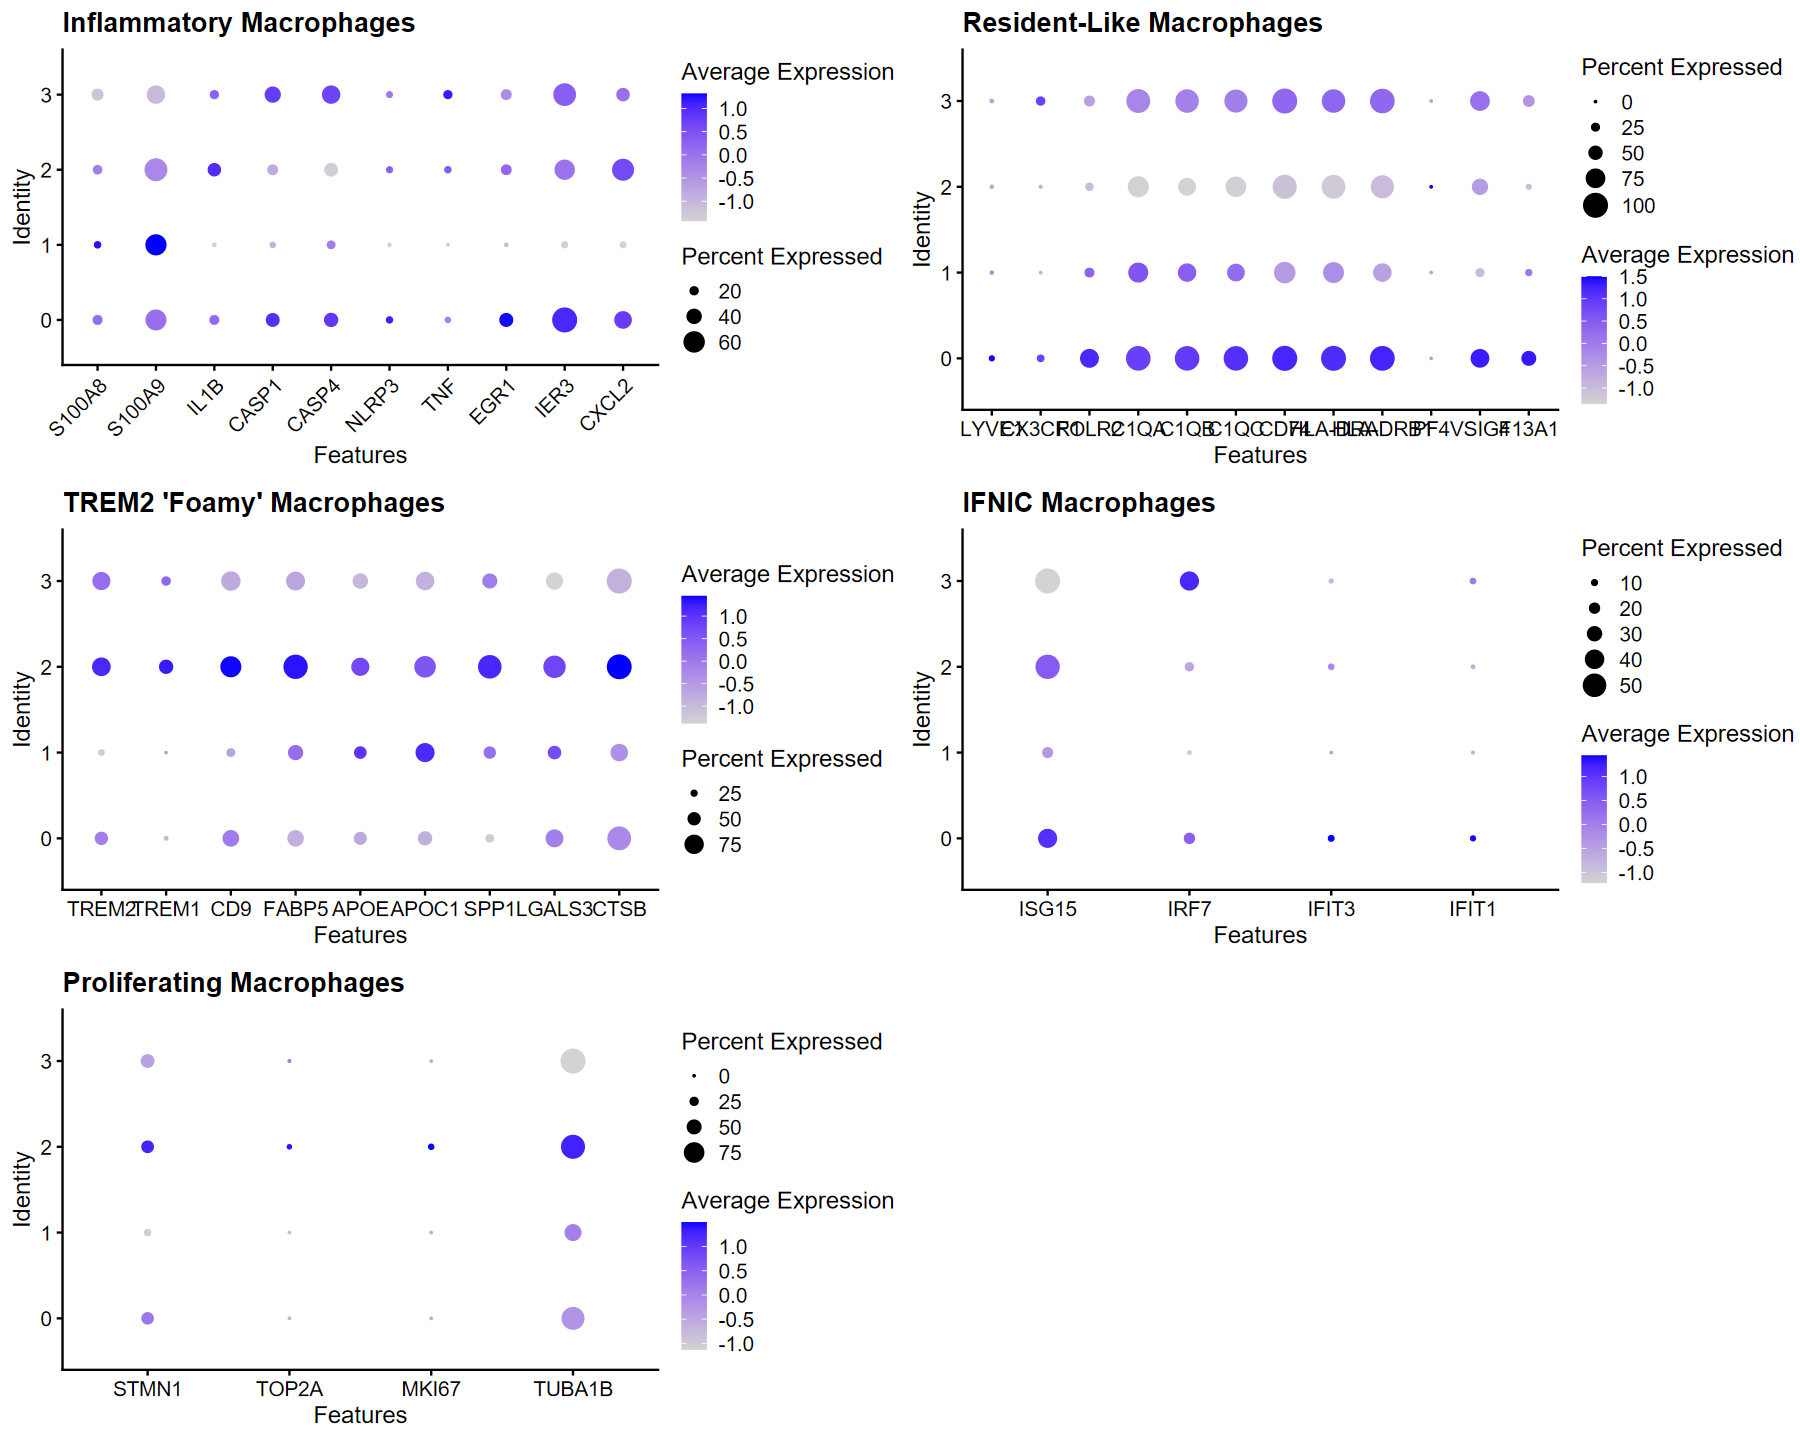

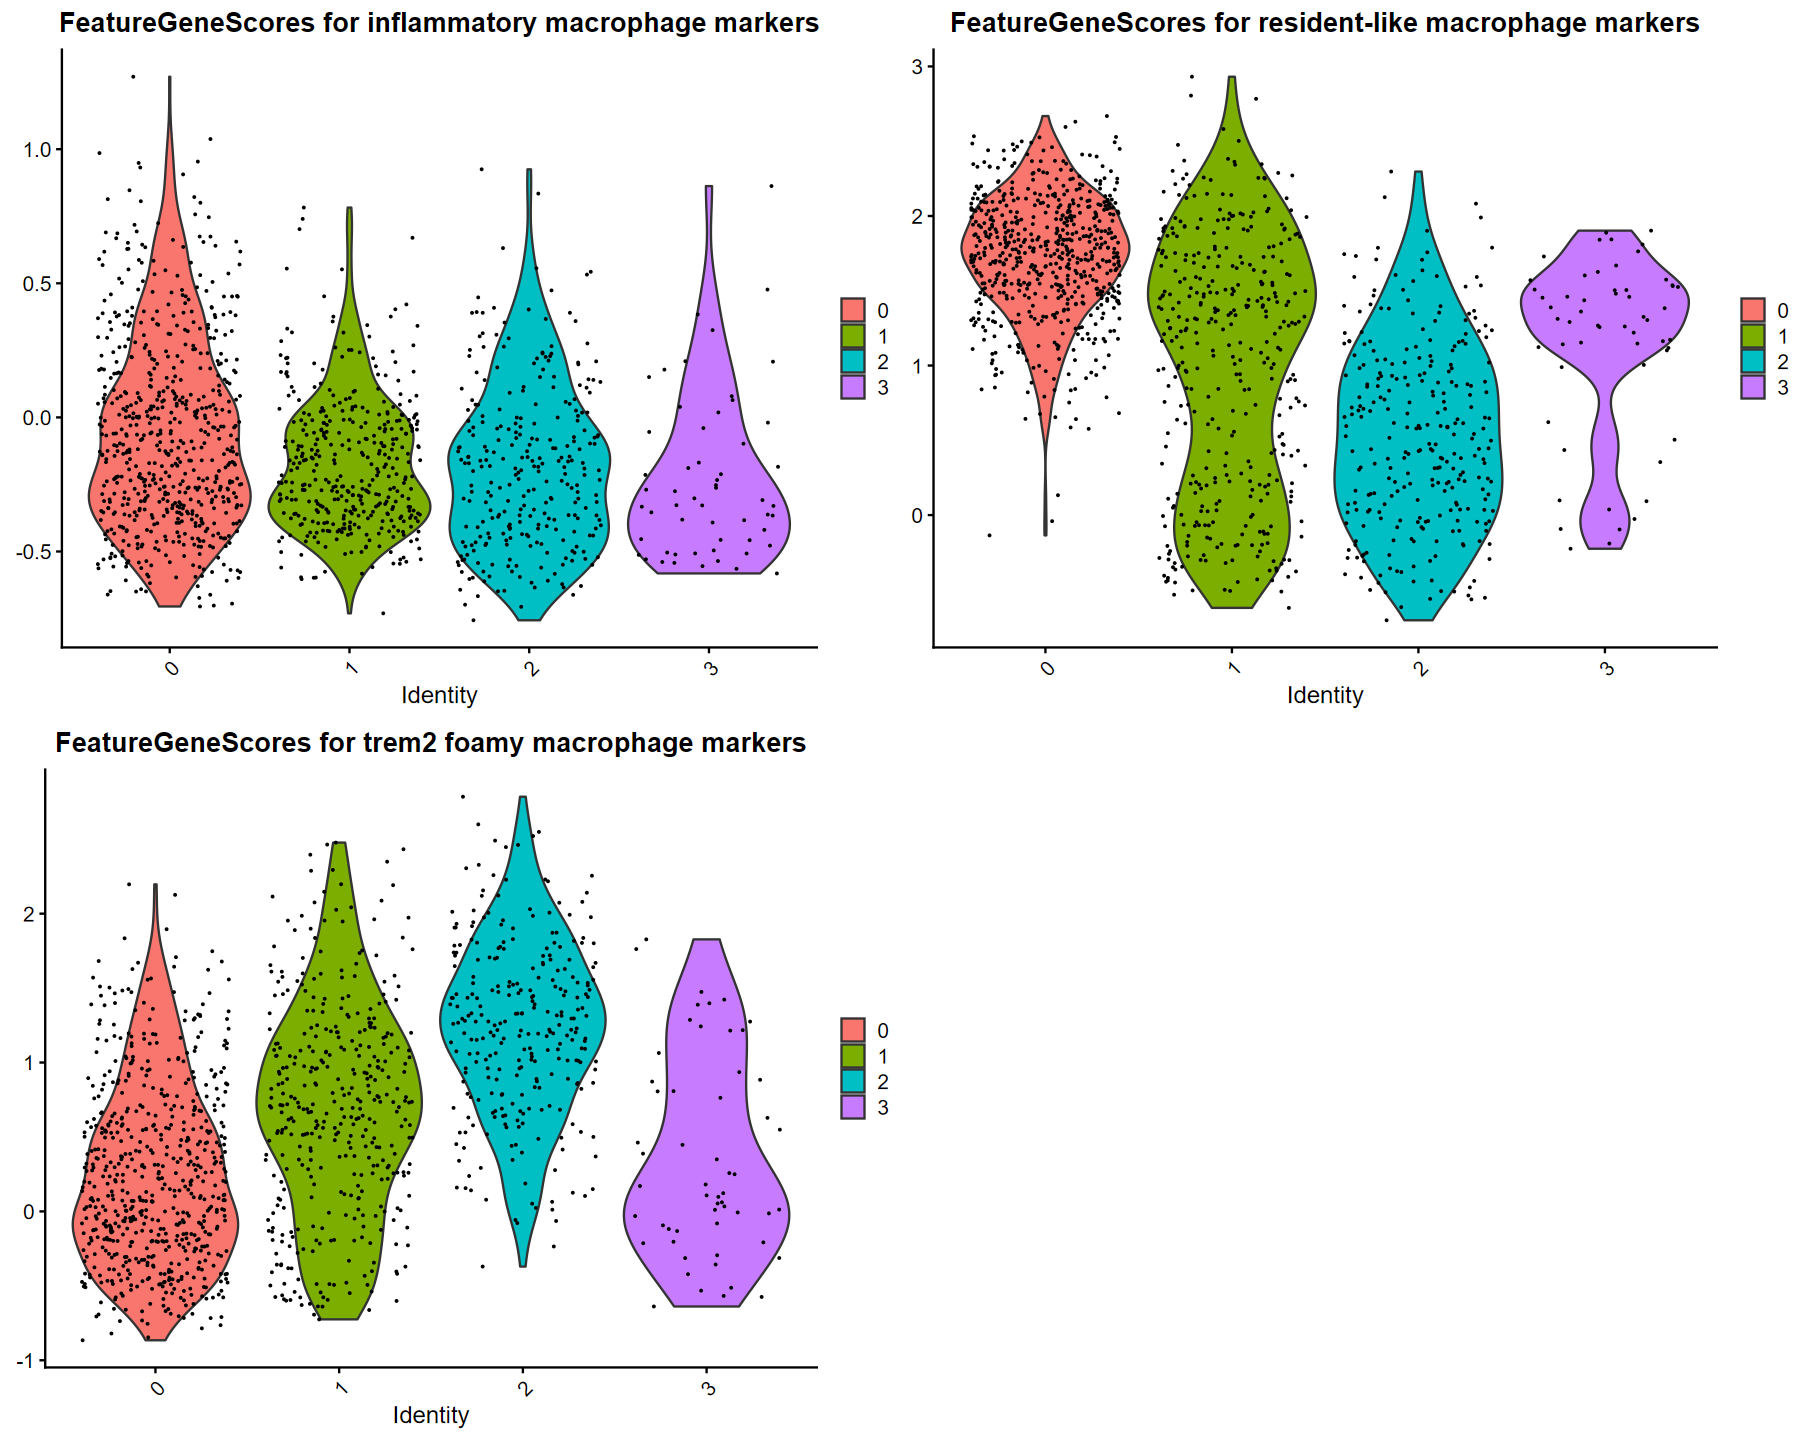

In [88]:
# Change setting for visualizing plots within VSCODE
options(repr.plot.width=15, repr.plot.height=12)
# Plot
grid.arrange(inflammatory_dot, resident_dot, TREM2_dot, IFNIC_dot, proliferating_dot, ncol = 2)
grid.arrange(inflammatory_vln, residents_vln, trem2_vln, ncol=2)


In [89]:
# Assign new labels
#macrophage_data <- RenameIdents(macrophage_data,
#                                   '0' = 'Resident-like Macrophages',
#                                   '1' = 'Resident-like Macrophages',
#                                   '2' = 'TREM2 Foamy Macrophages', 
#                                   '3' = 'Inflammatory Macrophages',
#                                   '4' = 'TREM2 Foamy Macrophages',
#                                   '5' = 'TREM2 Foamy Macrophages', # Wss TREM2 Foamy
#                                   '6' = 'Proliferating Macrophages',
#                                   '7' = 'IFNIC Macrophages')

macrophage_data <- RenameIdents(macrophage_data,
                                   '0' = 'Inflammatory Macrophages',
                                   '1' = 'Resident-like Macrophages',
                                   '2' = 'TREM2 Foamy Macrophages',
                                   '3' = 'Resident-like Macrophages')

# Proportion tables
annotations_per_origin <- table(Idents(macrophage_data), macrophage_data$orig.ident)
annotations_per_origin_prop <- prop.table(table(Idents(macrophage_data), macrophage_data$orig.ident), margin = 2) * 100
annotations_total <- prop.table(table(Idents(macrophage_data))) * 100

# Subtype plots after annotation
subtype_annotated_plot <- DimPlot(macrophage_data, reduction = "umap", label = TRUE)
subtype_origin_plot <- DimPlot(macrophage_data, reduction = "umap", group.by = "orig.ident", label = TRUE)


# Combine tables side by side
combined_df <- cbind(annotations_per_origin, annotations_per_origin_prop, annotations_total)

P1 P2  P3  P5  P6  P7 P1       P2        P3      
Inflammatory Macrophages  66 120 181 114 114 29 65.34653 55.555556 56.03715
Resident-like Macrophages 24  75  88  96 100 59 23.76238 34.722222 27.24458
TREM2 Foamy Macrophages   11  21  54  46 112 34 10.89109  9.722222 16.71827
                          P5       P6       P7       annotations_total
Inflammatory Macrophages  44.53125 34.96933 23.77049 46.42857         
Resident-like Macrophages 37.50000 30.67485 48.36066 32.88690         
TREM2 Foamy Macrophages   17.96875 34.35583 27.86885 20.68452

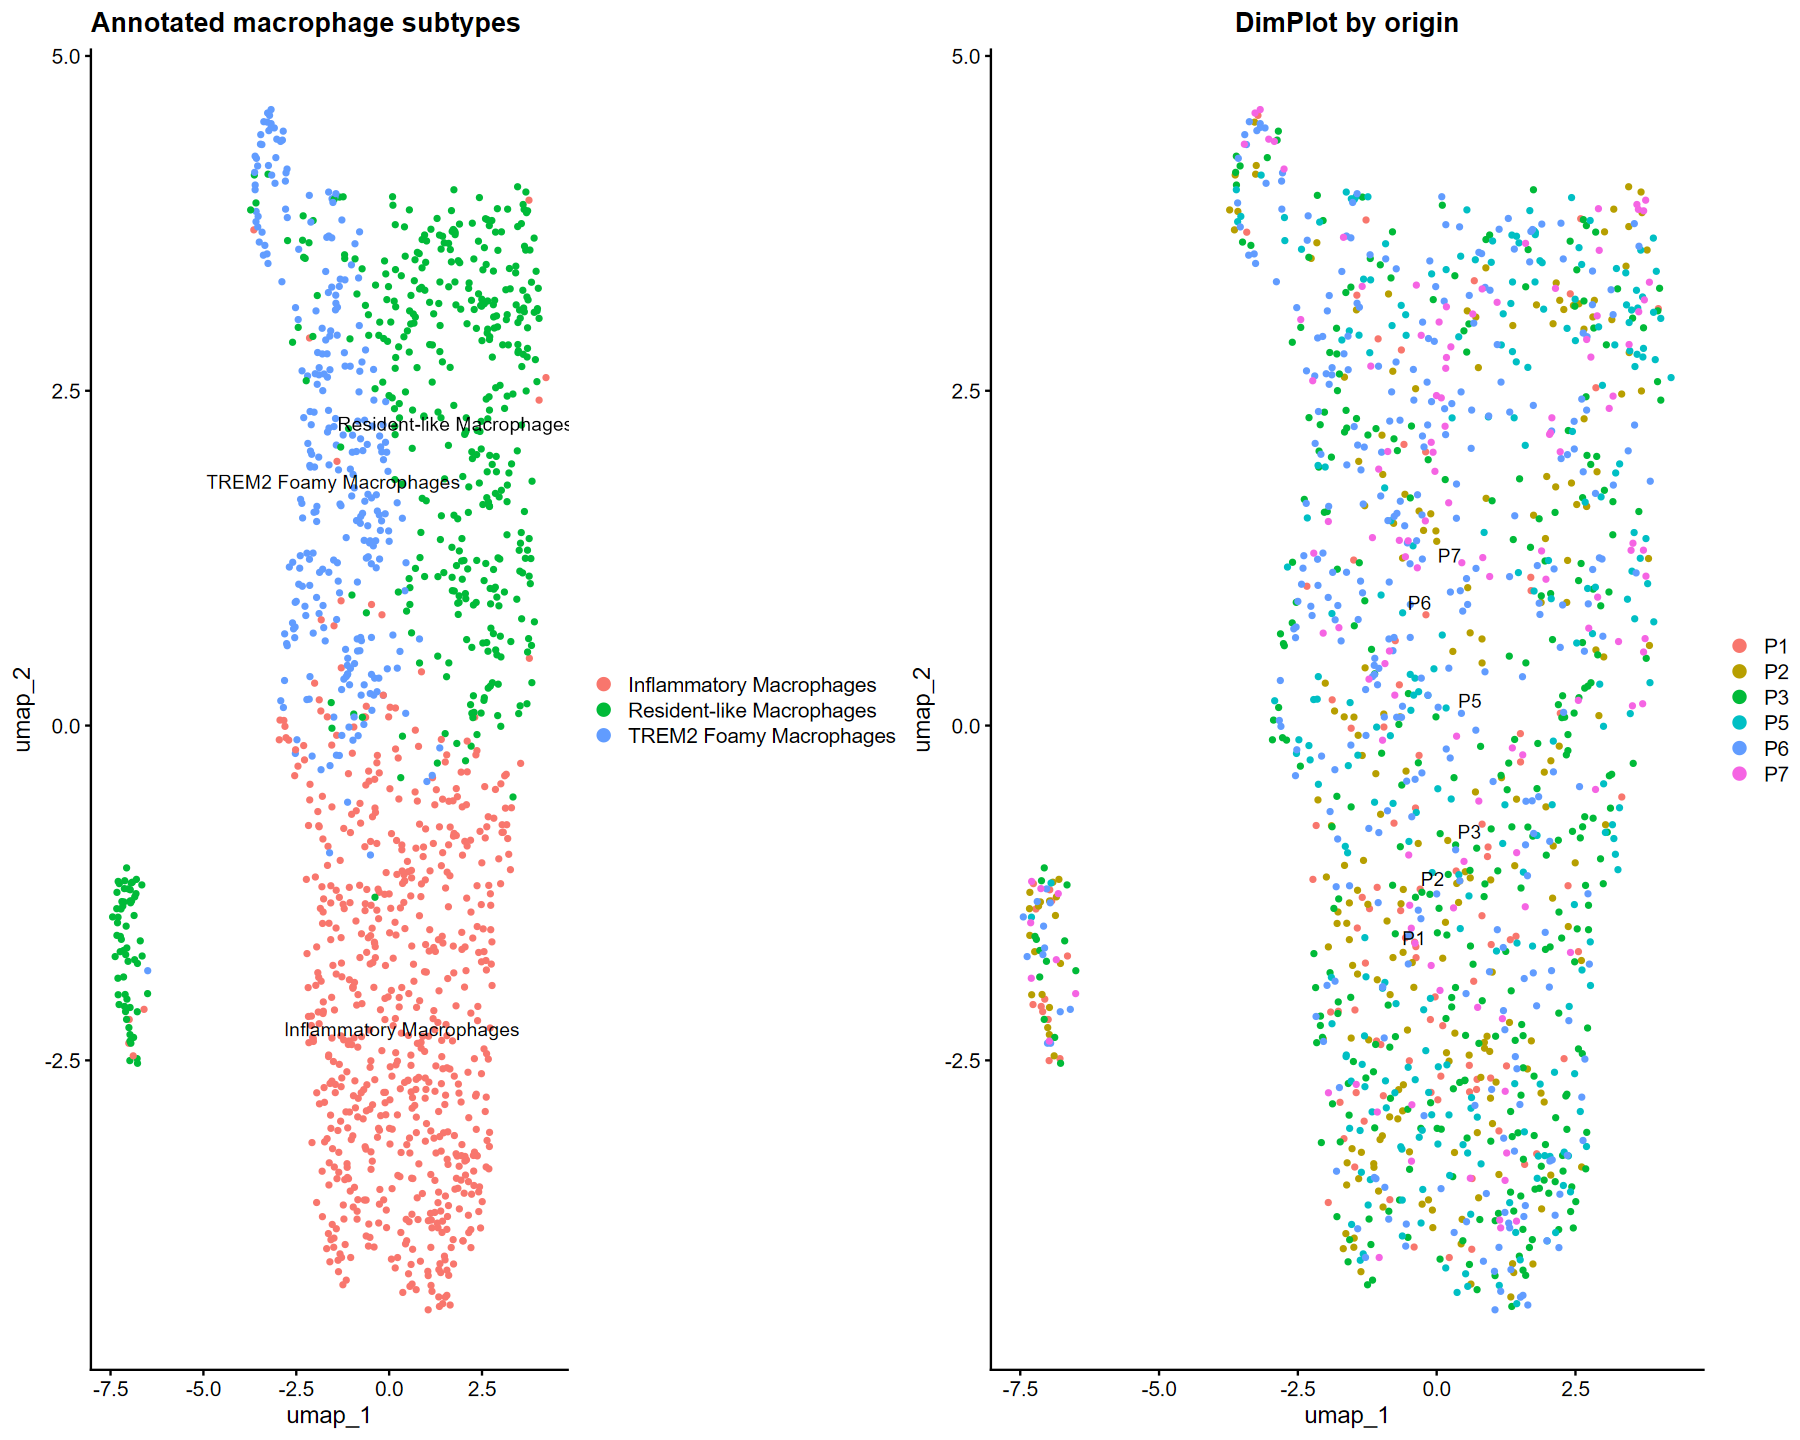

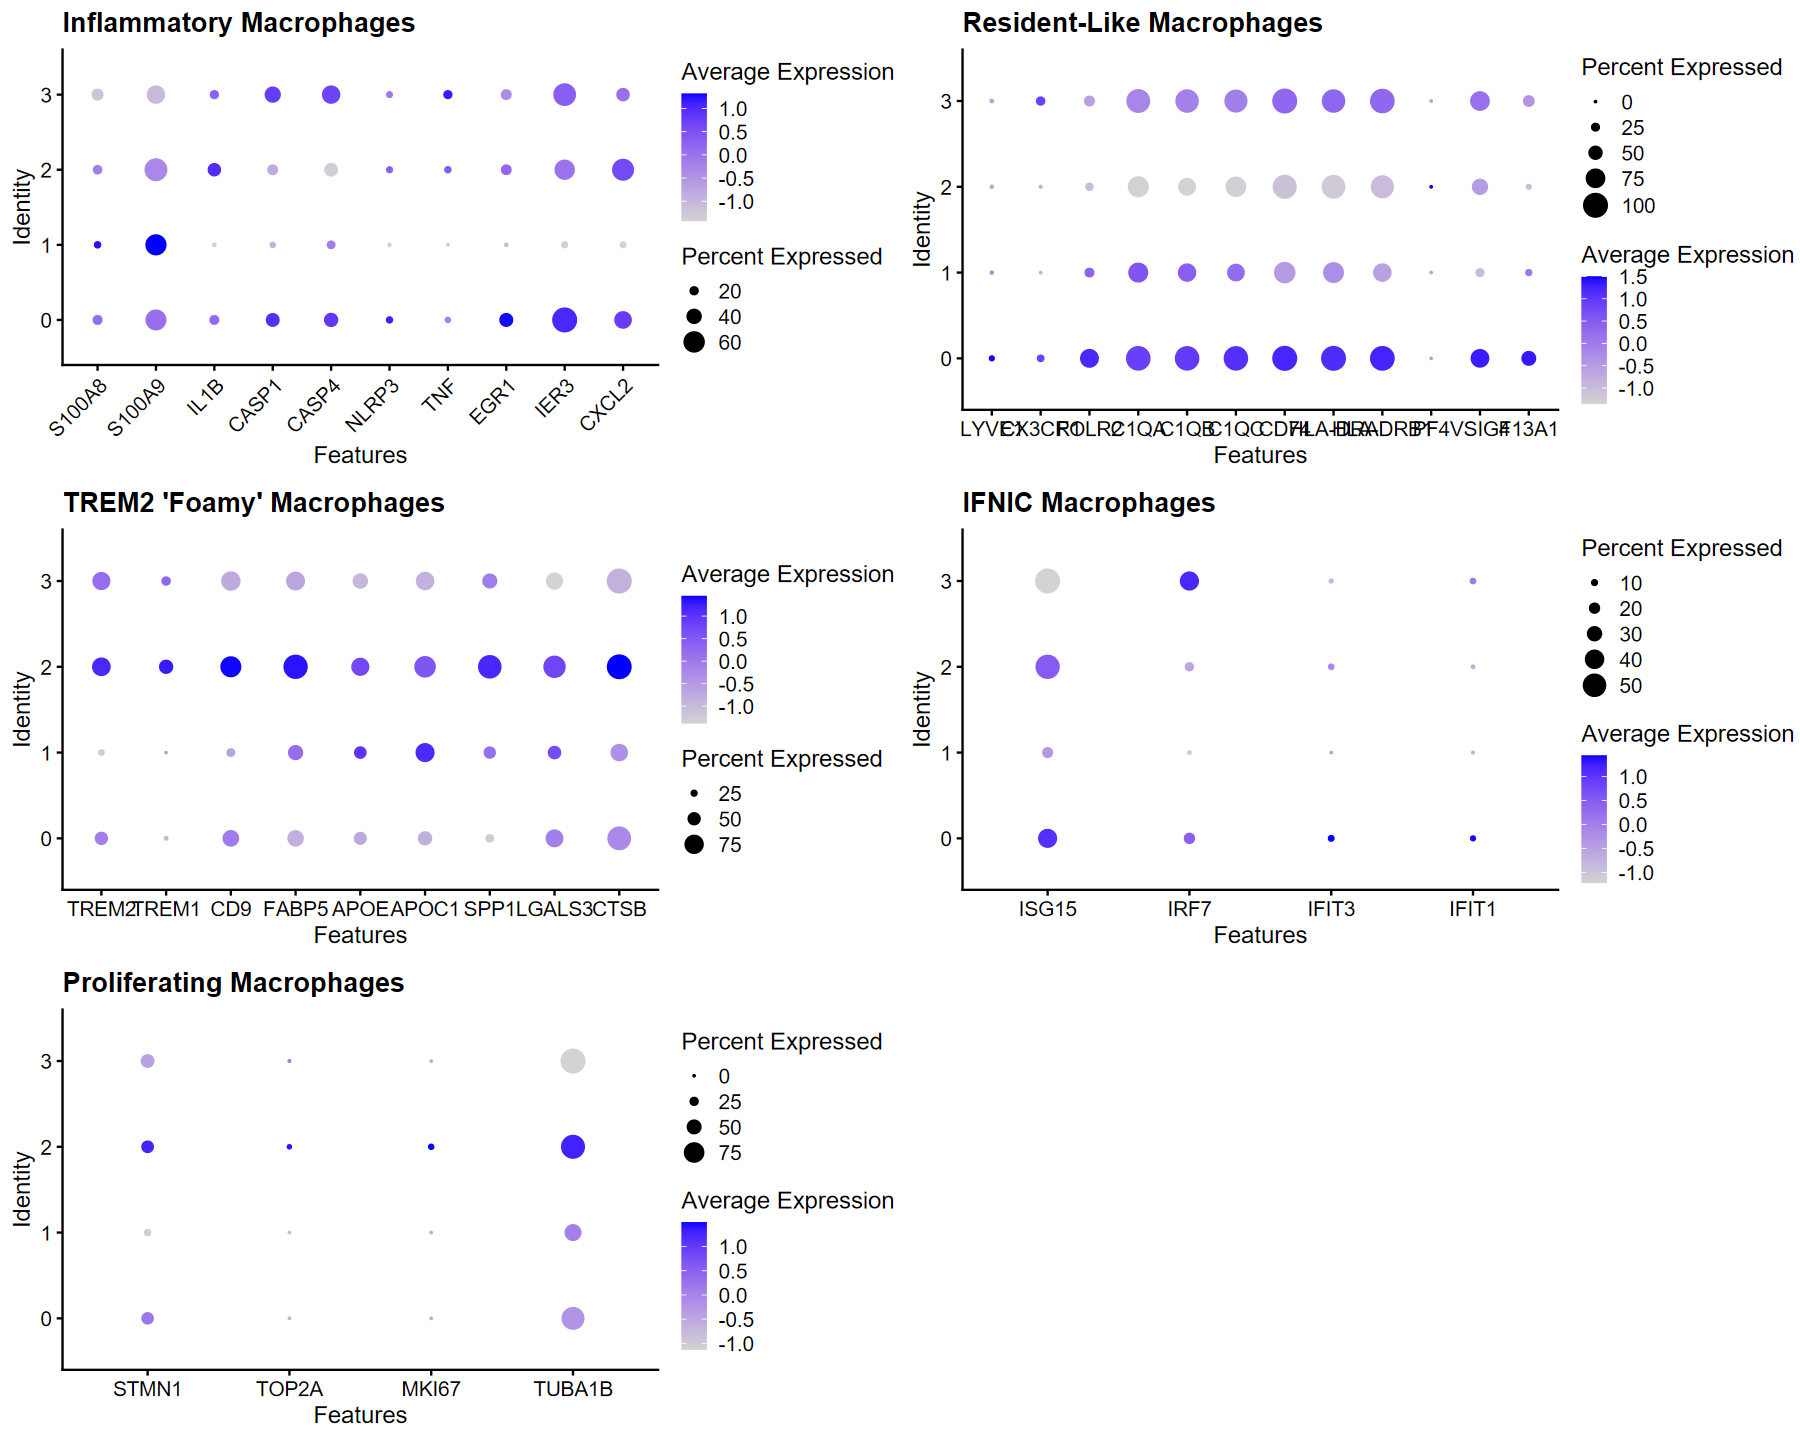

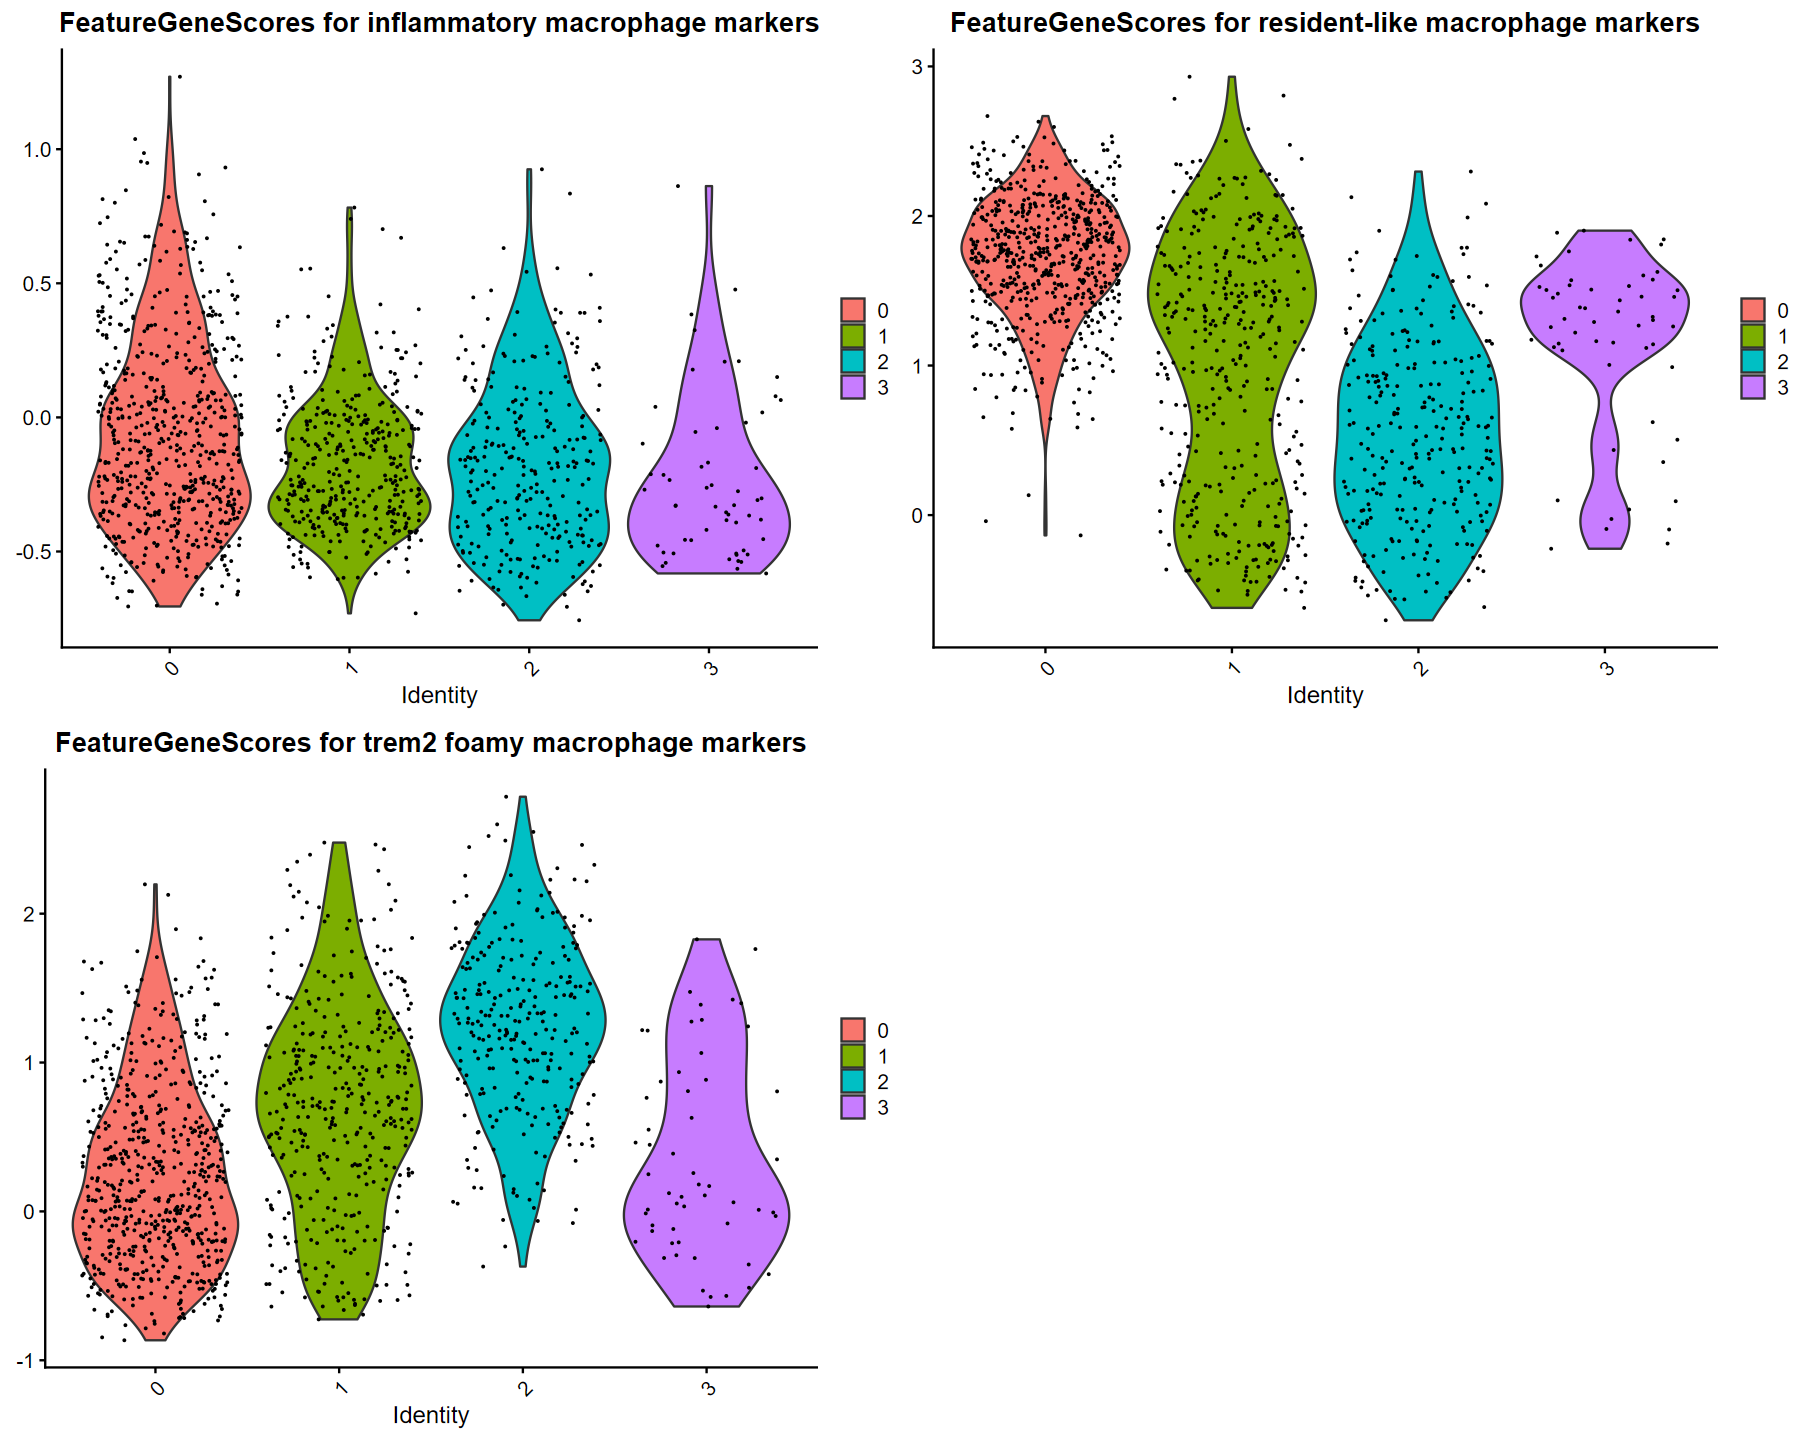

In [90]:
# Plot table
combined_df

# Plotting annotations and titles
grid.arrange(
    subtype_annotated_plot + ggtitle("Annotated macrophage subtypes"),
    subtype_origin_plot + ggtitle("DimPlot by origin"),
    ncol=2
)

grid.arrange(inflammatory_dot, resident_dot, TREM2_dot, IFNIC_dot, proliferating_dot, ncol = 2)
grid.arrange(inflammatory_vln, residents_vln, trem2_vln, ncol=2)

In [91]:
# Save final object
saveRDS(macrophage_data, file = "Dib_macrophages_annotated.rds")